In [ ]:
!unzip open.zip

Archive:  open.zip
  inflating: sample_submission.csv   
  inflating: test_data.csv           
  inflating: topic_dict.csv          
  inflating: train_data.csv          


In [ ]:
!pip install transformers==3.0.2

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from transformers import AutoTokenizer, AutoModelWithLMHead, AutoModel
# GPT2ForSequenceClassification

warnings.filterwarnings('ignore')

In [ ]:
tr = pd.read_csv('train_data.csv', index_col='index')

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained("skt/kogpt2-base-v2")
tokenizer=AutoTokenizer.from_pretrained('monologg/kobert')

# model = GPT2ForSequenceClassification.from_pretrained("skt/kogpt2-base-v2")
model=AutoModel.from_pretrained('monologg/kobert')

model.score = torch.nn.Linear(768, 7)
model.cuda()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(8002, 768, padding_idx=1)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )

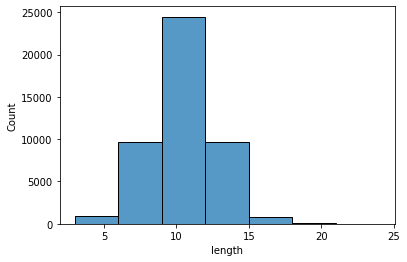

In [ ]:
tr['length']=tr['title'].apply(lambda line:len(tokenizer.encode(line)))

import seaborn as sns

sns.histplot(data=tr, x="length", binwidth=3)

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, data, tokenizer, max_seq_len=30): ## 40 수정.
        self.data = data
        self.max_seq_len = max_seq_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        record = self.data.iloc[index]
        document, label = str(record['title']), int(record['topic_idx'])
        tokens = self.tokenizer.tokenize(document)
        encoder_input_id = self.tokenizer.convert_tokens_to_ids(tokens)
        attention_mask = [1] * len(encoder_input_id)
        if len(encoder_input_id) < self.max_seq_len:
            while len(encoder_input_id) < self.max_seq_len:
                # encoder_input_id += [tokenizer.convert_tokens_to_ids('<pad>')]
                encoder_input_id += [tokenizer.convert_tokens_to_ids('[PAD]')]
                attention_mask += [0]
        else:
            encoder_input_id = encoder_input_id[:self.max_seq_len - 1] + [
                self.tokenizer.eos_token_id]
            attention_mask = attention_mask[:self.max_seq_len]
        return {'input_ids': np.array(encoder_input_id, dtype=np.int_),
                'attention_mask': np.array(attention_mask, dtype=np.float),
                'labels': np.array(label, dtype=np.int_)}


In [ ]:
class TestDataset(Dataset):
    def __init__(self, data, tokenizer, max_seq_len=30):
        self.data = data
        self.max_seq_len = max_seq_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        record = self.data.iloc[index]
        document = str(record['title'])
        tokens = self.tokenizer.tokenize(document)
        encoder_input_id = self.tokenizer.convert_tokens_to_ids(tokens)
        attention_mask = [1] * len(encoder_input_id)
        if len(encoder_input_id) < self.max_seq_len:
            while len(encoder_input_id) < self.max_seq_len:
                # encoder_input_id += [tokenizer.convert_tokens_to_ids('<pad>')]
                encoder_input_id += [tokenizer.convert_tokens_to_ids('[PAD]')]
                attention_mask += [0]
        else:
            encoder_input_id = encoder_input_id[:self.max_seq_len - 1] + [
                self.tokenizer.eos_token_id]
            attention_mask = attention_mask[:self.max_seq_len]
        return {'input_ids': np.array(encoder_input_id, dtype=np.int_),
                'attention_mask': np.array(attention_mask, dtype=np.float)}

In [ ]:
# train parameters
epochs = 10
# batch_size = 32
batch_size=64

In [ ]:
# train loader
train_ds = TrainDataset(tr, tokenizer)
loader = DataLoader(train_ds, batch_size=batch_size, num_workers=0, shuffle=True)

In [ ]:
# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 5, )
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
model.train()
for e in range(epochs):
    total_loss = 0
    for batch in loader:
        optimizer.zero_grad()
        ids, atts, labels = batch['input_ids'], batch['attention_mask'], batch['labels']
        ids = torch.tensor(ids).long().cuda()
        atts = torch.tensor(atts).long().cuda()
        labels = torch.tensor(labels).long().cuda()
        pred = model(ids, attention_mask=atts)
        loss = loss_fn(pred[-1], labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()
        total_loss += loss.item()
        
    scheduler.step()
    print(e, total_loss)

0 3384.032727241516
1 3356.2612824440002
2 3356.139867782593
3 3356.1127762794495
4 3356.104773044586
5 3356.1029567718506
6 3356.1005024909973
7 3356.0919399261475
8 3356.0837597846985
9 3356.081027507782


In [ ]:
# test loader
te = pd.read_csv('test_data.csv', index_col='index')

test_ds = TestDataset(te, tokenizer)
test_loader = DataLoader(test_ds, 32) ## 8 수정

In [ ]:
preds = []
model.eval()

for b in tqdm(test_loader):
    ids, atts = b['input_ids'], b['attention_mask']
    ids = torch.tensor(ids).long().cuda()
    atts = torch.tensor(atts).long().cuda()
    pred = model(ids, attention_mask=atts)
    preds += list(np.argmax(pred[0].detach().cpu().numpy(), 1))
#     break

 90%|████████▉ | 256/286 [00:16<00:01, 15.53it/s]

In [ ]:
sub = pd.read_csv('sample_submission.csv', index_col='index')
sub['topic_idx'] = preds
sub.head(20)

In [ ]:
sub.to_csv('gpt.csv',index=False)

In [ ]:
## kobert

!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3.0.2
!pip install torch

     |████████████████████████████████| 46.9 MB 42 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 344 kB 8.2 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595733 sha256=f8715a5f4edfdffc998bf4c6b40acb491455cf88d80d42d89680b24688b4dddf
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
     |████████████████████████████████| 1.2 MB 8.5 MB/s 
     |████████████████████████████████| 769 kB 8.1 MB/s 
     |████████████████████████████████| 895 kB 42.6 MB/s 
     |████████████████████████████████| 3.0 MB 61.4 MB/s 


In [ ]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-hz43byhk
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-hz43byhk
  Created wheel for kobert: filename=kobert-0.1.2-py3-none-any.whl size=12770 sha256=b9160f43a55168f7f3d58086f890d29c446cf0637cd0f4d3fda68276ccc83e22
  Stored in directory: /tmp/pip-ephem-wheel-cache-7h25sdws/wheels/d3/68/ca/334747dfb038313b49cf71f84832a33372f3470d9ddfd051c0
Successfully built kobert


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [ ]:
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
##GPU 사용 시
device = torch.device("cuda:0")

In [ ]:
bertmodel, vocab = get_pytorch_kobert_model()

[██████████████████████████████████████████████████]
[██████████████████████████████████████████████████]


In [ ]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model


In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [ ]:
import pandas as pd
data=pd.read_csv('train_data.csv',index_col='index')

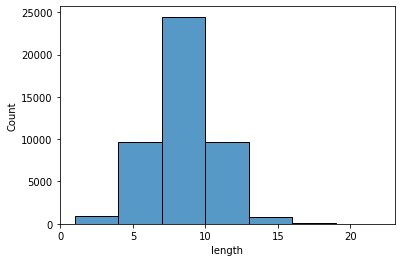

In [ ]:
data['length']=data['title'].apply(lambda line:len(tok.basic_tokenizer(line)))

import seaborn as sns

sns.histplot(data=data, x="length", binwidth=3)

In [ ]:
## Setting parameters
# max_len = 64
max_len=30
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['title'],data['topic_idx'],test_size=0.33, random_state=42,stratify=data['topic_idx'])

dataset_train=[]
dataset_test=[]

for i in X_train.index:
    dataset_train.append((X_train[i],y_train[i]))

for i in X_test.index:
    dataset_test.append((X_test[i],y_test[i]))

In [ ]:
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                #  num_classes=2,
                 num_classes=7,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
kobert_model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

In [ ]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in kobert_model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in kobert_model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [ ]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [ ]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [ ]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [ ]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    kobert_model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = kobert_model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(kobert_model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    kobert_model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = kobert_model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 2.0018093585968018 train acc 0.125
epoch 1 batch id 201 loss 0.6843147873878479 train acc 0.5813121890547264
epoch 1 batch id 401 loss 0.36218738555908203 train acc 0.7211268703241895

epoch 1 train acc 0.7446521966527198


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



epoch 1 test acc 0.8744143171447196


epoch 2 batch id 1 loss 0.2758248448371887 train acc 0.875
epoch 2 batch id 201 loss 0.5010300874710083 train acc 0.8770988805970149
epoch 2 batch id 401 loss 0.19409319758415222 train acc 0.8906639650872819

epoch 2 train acc 0.8933228730822873



epoch 2 test acc 0.8811624022164277


epoch 3 batch id 1 loss 0.21294812858104706 train acc 0.90625
epoch 3 batch id 201 loss 0.3917968273162842 train acc 0.9196983830845771
epoch 3 batch id 401 loss 0.12354829162359238 train acc 0.9262390897755611

epoch 3 train acc 0.9286698047419805



epoch 3 test acc 0.8853996903520209


epoch 4 batch id 1 loss 0.11057659983634949 train acc 0.953125
epoch 4 batch id 201 loss 0.32506003975868225 train acc 0.9463619402985075
epoch 4 batch id 401 loss 0.030524158850312233 train acc 0.9523846633416458

epoch 4 train acc 0.9538114539748954



epoch 4 test acc 0.8824559973924381


epoch 5 batch id 1 loss 0.11352106928825378 train acc 0.953125
epoch 5 batch id 201 loss 0.22057586908340454 train acc 0.9675062189054726
epoch 5 batch id 401 loss 0.030096247792243958 train acc 0.9698020573566085

epoch 5 train acc 0.9703517259414226



epoch 5 test acc 0.8838820078226858


In [ ]:
test=pd.read_csv('test_data.csv',index_col='index')

transform = nlp.data.BERTSentenceTransform(tok, max_seq_length=max_len, pad=True, pair=False)

answer=[]

with torch.no_grad():
    kobert_model.eval()
    for sentence in test['title']:
        token_ids, valid_length, segment_ids=transform(sentence)
        token_ids=torch.tensor([token_ids],dtype=torch.int32).long().to(device)
        valid_length=torch.tensor([valid_length.tolist()],dtype=torch.int32)
        segment_ids=torch.tensor([segment_ids],dtype=torch.int32).long().to(device)

        pred=kobert_model(token_ids,valid_length,segment_ids)
        pred=pred[0].argmax().detach().cpu().numpy().item()
        
        answer.append(pred)

In [ ]:
submit=pd.read_csv('sample_submission.csv')

In [ ]:
submit['topic_idx']=answer
submit.head()

,index,topic_idx
0,45654,2
1,45655,2
2,45656,3
3,45657,3
4,45658,2


In [ ]:
submit.to_csv('20210804_kobert.csv',index=False)

In [3]:
## koelectra

!unzip open.zip

Archive:  open.zip
  inflating: sample_submission.csv   
  inflating: test_data.csv           
  inflating: topic_dict.csv          
  inflating: train_data.csv          


In [5]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 7.0 MB/s 
     |████████████████████████████████| 636 kB 49.6 MB/s 
     |████████████████████████████████| 895 kB 55.5 MB/s 
     |████████████████████████████████| 3.3 MB 61.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [6]:
import pandas as pd
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, ElectraForSequenceClassification, AdamW
from tqdm.notebook import tqdm

In [7]:
# GPU 사용
device = torch.device("cuda")

In [8]:
tr = pd.read_csv('train_data.csv', index_col='index')
ts = pd.read_csv('test_data.csv', index_col='index')
submit = pd.read_csv('sample_submission.csv')

In [23]:
tokenizer=AutoTokenizer.from_pretrained("monologg/koelectra-small-v2-discriminator")

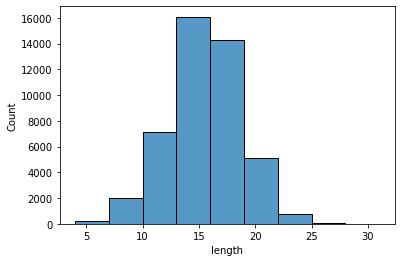

In [24]:
tr['length']=tr['title'].apply(lambda line:len(tokenizer.encode(line)))

import seaborn as sns

sns.histplot(data=tr, x="length", binwidth=3)

In [38]:
class TrainDataset(Dataset):
  
  def __init__(self, data):
    self.tokenizer = tokenizer
    self.data=data

  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    row = self.data.iloc[idx,:2].values
    text = row[0]
    y = row[1]

    inputs = self.tokenizer(
        text, 
        return_tensors='pt',
        truncation=True,
        max_length=30,
        pad_to_max_length=True,
        add_special_tokens=True
        )
    
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]

    return input_ids, attention_mask, y


class TestDataset(Dataset):

    def __init__(self,data):
        self.data=data
        self.tokenizer=tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        row=self.data.iloc[idx,:2].values
        text=row[0]

        inputs=self.tokenizer(text,return_tensors='pt',
                              truncation=True,max_length=30,
                              pad_to_max_length=True,
                              add_special_tokens=True)
        
        input_ids=inputs['input_ids'][0]
        attention_mask=inputs['attention_mask'][0]
        return input_ids, attention_mask
        

In [39]:
train_dataset = TrainDataset(tr)
test_dataset = TestDataset(ts)

In [42]:
model = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-small-v2-discriminator").to(device)
model.classifier.out_proj=torch.nn.Linear(256,7)
model.cuda()
# 한번 실행해보기
text, attention_mask, y = train_dataset[0]
model(text.unsqueeze(0).to(device), attention_mask=attention_mask.unsqueeze(0).to(device))

Some weights of the model checkpoint at monologg/koelectra-small-v2-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v2-discriminator and are newly initialized

SequenceClassifierOutput([('logits',
                           tensor([[ 0.0353, -0.0650,  0.0058, -0.0998,  0.0315,  0.0342, -0.0105]],
                                  device='cuda:0', grad_fn=<AddmmBackward>))])

In [43]:
epochs = 3
batch_size = 64

optimizer = AdamW(model.parameters(), lr=1e-5)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [44]:
losses = []
accuracies = []

for i in range(epochs):
  total_loss = 0.0
  correct = 0
  total = 0
  batches = 0

  model.train()

  for input_ids_batch, attention_masks_batch, y_batch in tqdm(train_loader):
    optimizer.zero_grad()
    y_batch = y_batch.to(device)
    y_pred = model(input_ids_batch.to(device), attention_mask=attention_masks_batch.to(device))[0]
    loss = F.cross_entropy(y_pred, y_batch)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    _, predicted = torch.max(y_pred, 1)
    correct += (predicted == y_batch).sum()
    total += len(y_batch)

    batches += 1
    if batches % 100 == 0:
      print("Batch Loss:", total_loss, "Accuracy:", correct.float() / total)
  
  losses.append(total_loss)
  accuracies.append(correct.float() / total)
  print("Train Loss:", total_loss, "Accuracy:", correct.float() / total)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Batch Loss: 192.87390732765198 Accuracy: tensor(0.2259, device='cuda:0')
Batch Loss: 378.2096527814865 Accuracy: tensor(0.3090, device='cuda:0')
Batch Loss: 538.6433544158936 Accuracy: tensor(0.3975, device='cuda:0')
Batch Loss: 674.8506858348846 Accuracy: tensor(0.4681, device='cuda:0')
Batch Loss: 793.3005422353745 Accuracy: tensor(0.5212, device='cuda:0')
Batch Loss: 894.8379296064377 Accuracy: tensor(0.5649, device='cuda:0')
Batch Loss: 984.5174924135208 Accuracy: tensor(0.5990, device='cuda:0')

Train Loss: 995.7680749297142 Accuracy: tensor(0.6036, device='cuda:0')


Batch Loss: 78.30998039245605 Accuracy: tensor(0.8234, device='cuda:0')
Batch Loss: 147.50705045461655 Accuracy: tensor(0.8294, device='cuda:0')
Batch Loss: 212.8536792099476 Accuracy: tensor(0.8318, device='cuda:0')
Batch Loss: 271.61175149679184 Accuracy: tensor(0.8346, device='cuda:0')
Batch Loss: 326.9824519753456 Accuracy: tensor(0.8382, device='cuda:0')
Batch Loss: 381.9069330692291 Accuracy: tensor(0.8393, device='cuda:0')
Batch Loss: 433.5090474486351 Accuracy: tensor(0.8416, device='cuda:0')

Train Loss: 440.7499286532402 Accuracy: tensor(0.8417, device='cuda:0')


Batch Loss: 49.004444032907486 Accuracy: tensor(0.8572, device='cuda:0')
Batch Loss: 96.56530098617077 Accuracy: tensor(0.8592, device='cuda:0')
Batch Loss: 142.17987076938152 Accuracy: tensor(0.8615, device='cuda:0')
Batch Loss: 188.56039516627789 Accuracy: tensor(0.8604, device='cuda:0')
Batch Loss: 233.46605087816715 Accuracy: tensor(0.8606, device='cuda:0')
Batch Loss: 277.36222441494465 Accuracy: tensor(0.8612, device='cuda:0')
Batch Loss: 321.6426482051611 Accuracy: tensor(0.8615, device='cuda:0')

Train Loss: 327.83642099797726 Accuracy: tensor(0.8615, device='cuda:0')


In [45]:
losses, accuracies

([995.7680749297142, 440.7499286532402, 327.83642099797726],
 [tensor(0.6036, device='cuda:0'),
  tensor(0.8417, device='cuda:0'),
  tensor(0.8615, device='cuda:0')])

In [50]:
model.eval()
answer=[]

for input_ids_batch, attention_masks_batch in tqdm(test_loader):
  y_batch = y_batch.to(device)
  y_pred = model(input_ids_batch.to(device), attention_mask=attention_masks_batch.to(device))[0]
  _, predicted = torch.max(y_pred, 1)
  answer+=predicted.detach().cpu().numpy().tolist()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [56]:
submit['topic_idx']=answer
submit.head()

,index,topic_idx
0,45654,0
1,45655,3
2,45656,2
3,45657,2
4,45658,3


In [57]:
submit.to_csv('20210805_koelectra.csv',index=False)